<a href="https://colab.research.google.com/github/shemaaali/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment/SDA8_LS_DS18_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [21]:
%%capture
import sys
 
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
 
# If you're working locally:
else:
    DATA_PATH = '../data/'

In [22]:
import pandas as pd
 
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
 
# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
 
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
 
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)
 
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [4]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

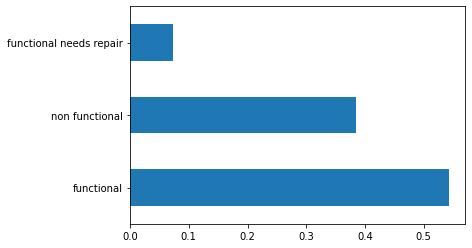

In [5]:
train['status_group'].value_counts(normalize=True).plot(kind='barh');

In [24]:
train['status_group'].apply(lambda x: 0 if x =='functional' else 1).head()

43360    0
7263     0
2486     0
313      1
52726    0
Name: status_group, dtype: int64

In [25]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
 
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
 
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer features
    X['years'] = X['year_recorded'] - X['construction_year']
    
    # Add target feature
    if 'status_group' in X.columns:
      X['needs_repair'] = X['status_group'].apply(lambda x: 0 if x =='functional' else 1)
      X.drop('status_group', axis=1, inplace=True)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X
 
# Merge train_features.csv & train_labels.csv
train = wrangle(pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')))
 
# Read test_features.csv & sample_submission.csv
test = wrangle(pd.read_csv(DATA_PATH+'waterpumps/test_features.csv'))
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

## EDA

In [8]:
import plotly.express as px

px.scatter(train, x='longitude', y='latitude', color='needs_repair', opacity=0.1)

In [9]:
# lotitude approximality is a zero, but it is not actually or quite a zero
train[['longitude', 'latitude']].describe()

longitude      latitude
count  57588.000000  57588.000000
mean      35.149669     -5.885572
std        2.607428      2.809876
min       29.607122    -11.649440
25%       33.285100     -8.643841
50%       35.005943     -5.172704
75%       37.233712     -3.372824
max       40.345193     -0.998464

In [10]:
# We can improve the location much better by making a scatter mapbox
# https://plot.ly/python/mapbox-layers/#base-maps-in-layoutmapboxstyle
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='needs_repair', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [26]:
# Selecting features
# The status_group column is the target
target = 'needs_repair'
 
# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target])
 
# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
 
# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
 
# Get a list of all categorical features with cardinality <= 10
categorical_features = cardinality[cardinality <=10].index.tolist()
 
# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'year_recorded', 'month_recorded', 'day_recorded', 'years', 'basin', 'public_meeting', 'permit', 'extraction_type_class', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


## Split Data

In [27]:
# Split train into train & val. Make val the same size as test.
target = 'needs_repair'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)
 
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

## BaseLine

In [13]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5430709115936238


## Build The Model

In [29]:
# Put all my models together into a single package by making a pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from scipy.stats import randint, uniform
from sklearn.feature_selection import f_regression, SelectKBest
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier

In [30]:
pipeline = make_pipeline(OrdinalEncoder( ),
                       SimpleImputer(strategy='mean'), 
                       StandardScaler(),
                       LogisticRegression(random_state=42)
)

In [31]:
X_train.shape

(45042, 40)

In [47]:
pipeline.fit(X_train, y_train);

In [34]:
y_pred = pipeline.predict(X_val)

In [35]:
# LogisticRegression Metrics
print('Traing Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:',pipeline.score(X_val, y_val))

Traing Accuracy: 0.6889347719905866
Validation Accuracy: 0.6911129683799973


In [41]:
from sklearn.tree import DecisionTreeClassifier

dt_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

In [42]:
dt_model.fit(X_train, y_train);

y_pred = pipeline.predict(X_val)

In [43]:
# Desicion Tree Metrics
print('Training Accuracy', dt_model.score(X_train, y_train))
print('Validation Accuracy', dt_model.score(X_val, y_val))

Training Accuracy 0.9999777984991786
Validation Accuracy 0.7403538097228026


In [116]:
# Make pipeline as a one package for all
pipeline2 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
)

In [124]:
paramtter = {'simpleimputer__strategy':['mean', 'most_frequent', 'median'],
             
             'randomforestclassifier__n_estimators': [5,10,20],
             'randomforestclassifier__max_depth': [4,10,15]}

In [126]:
research_R = RandomizedSearchCV(pipeline2,
                  param_distributions=paramtter,
                  n_iter=3,
                  n_jobs=-1,
                  return_train_score=True,
                  scoring='accuracy',
                  verbose=1,
                  cv=4)

In [127]:
research_R.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   16.7s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [128]:
research_R.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__n_estimators': 5,
 'simpleimputer__strategy': 'most_frequent'}

In [130]:
best_model_estimator = research_R.best_estimator_

In [132]:
print('Training Accuracy:', research_R.score(X_train, y_train))
print('Validation Accuracy:', research_R.score(X_val, y_val))

Training Accuracy: 0.8838417477021446
Validation Accuracy: 0.7965594093884942


In [133]:
# Fit on train, score on val
pipeline2.fit(X_train, y_train)
y_pred = pipeline2.predict(X_val)

In [134]:
print('Training Accuracy',  pipeline2.score(X_train, y_train))
print('Validation Accuracy',  pipeline2.score(X_val, y_val))

Training Accuracy 0.9992451489720705
Validation Accuracy 0.8187073408552723


In [142]:
 # Make a copy of my submission
 submission_be = sample_submission.copy()

In [143]:
# Prediction 
y_pred_be = pipeline2.predict(X_test)

In [146]:
# Converting the file into a csv file
submission_be['status_group'] = y_pred_be
submission_be.to_csv('Submission_Best_Estimator1.csv', index=False)

## Plot_Confusion_Matrix 

In [91]:
from sklearn.metrics import plot_confusion_matrix, classification_report

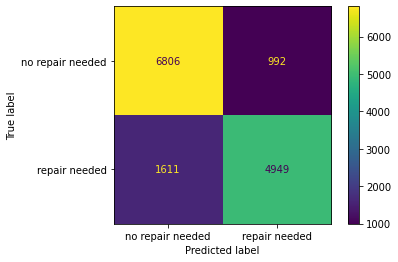

In [92]:
plot_confusion_matrix(pipeline2, X_val, y_val, 
                      values_format=".0f", 
                      display_labels=['no repair needed', 'repair needed']);

In [93]:
# print print classification_report
print(classification_report(y_val, pipeline2.predict(X_val)))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      7798
           1       0.83      0.75      0.79      6560

    accuracy                           0.82     14358
   macro avg       0.82      0.81      0.82     14358
weighted avg       0.82      0.82      0.82     14358



## Random Inspections

In [94]:
y_val.value_counts(normalize=True)

0    0.543112
1    0.456888
Name: needs_repair, dtype: float64

In [95]:
number_inspections = 1000
repair_prob =0.543112

In [96]:
print(f'With {number_inspections} random inspections, I expect to repair {number_inspections * repair_prob} pumps.')
print(f'With {number_inspections} random inspections, I expect to waste ${number_inspections * (1-repair_prob) * 100} in inspection costs.')

With 1000 random inspections, I expect to repair 543.1120000000001 pumps.
With 1000 random inspections, I expect to waste $45688.799999999996 in inspection costs.


## Inspection out of my model

In [97]:
# Create DataFrame
inspect_data = {'y_val': y_val, 
        'y_pred_prob': pipeline2.predict_proba(X_val)[:, -1]}
data_results = pd.DataFrame(inspect_data)

In [98]:
data_results

y_val  y_pred_prob
9041       1        0.850
14377      1        0.425
47372      0        0.575
562        0        0.175
38166      0        0.525
...      ...          ...
8729       1        0.775
51332      1        0.600
51212      0        0.550
49262      0        0.025
52763      1        0.625

[14358 rows x 2 columns]

In [100]:
# Create Predictions
predict_g = 0.851
data_results['y_pred'] = (data_results['y_pred_prob'] > predict_g).astype(int)

data_results.head()

y_val  y_pred_prob  y_pred
9041       1        0.850       0
14377      1        0.425       0
47372      0        0.575       0
562        0        0.175       0
38166      0        0.525       0

In [101]:
mask = data_results['y_pred'] == 0
sample = data_results[mask].sample(number_inspections)

In [102]:
print(f'With 1000 pumps that we identify as needing repair (predict_g {predict_g}), we expect to repair {sample.y_val.sum()}.')
print(f'We expect to waste ${(number_inspections - sample.y_val.sum()) * 100}.')

With 1000 pumps that we identify as needing repair (predict_g 0.851), we expect to repair 330.
We expect to waste $67000.


## Model Emphasis On Precision

In [103]:
def my_budget_repairs(predict_g=0.5):
 inspect_data = {'y_val': y_val, 
          'y_pred_prob': pipeline2.predict_proba(X_val)[:, -1]}
data_results = pd.DataFrame(data_results)

# Create Predictions
data_results['y_pred'] = (data_results['y_pred_prob'] > predict_g).astype(int)

mask = data_results['y_pred'] == 1
sample = data_results[mask].sample(number_inspections)

print(f'If I set my model predict_g set at {predict_g} and use it to select {number_inspections} pumps, I expect to repair {sample.y_val.sum()} pumps.')
print(f'I expect to waste ${(number_inspections - sample.y_val.sum()) * 100} in inspection costs.')

If I set my model predict_g set at 0.851 and use it to select 1000 pumps, I expect to repair 970 pumps.
I expect to waste $3000 in inspection costs.
